In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_excel('Superstore_Office_Supplies.xls')

In [3]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [4]:
df=df.loc[df['Category']=='Office Supplies',['Order Date','Sales']]

In [5]:
df.head()

,Order Date,Sales
2,2016-06-12,14.620
4,2015-10-11,22.368
6,2014-06-09,7.280
8,2014-06-09,18.504
9,2014-06-09,114.900


In [6]:
df.isna().sum()

Order Date    0
Sales         0
dtype: int64

In [7]:
ofc=df.groupby('Order Date')['Sales'].sum().reset_index()

In [8]:
ofc.set_index("Order Date", inplace=True)

In [9]:
y=ofc["Sales"].resample("M").mean()

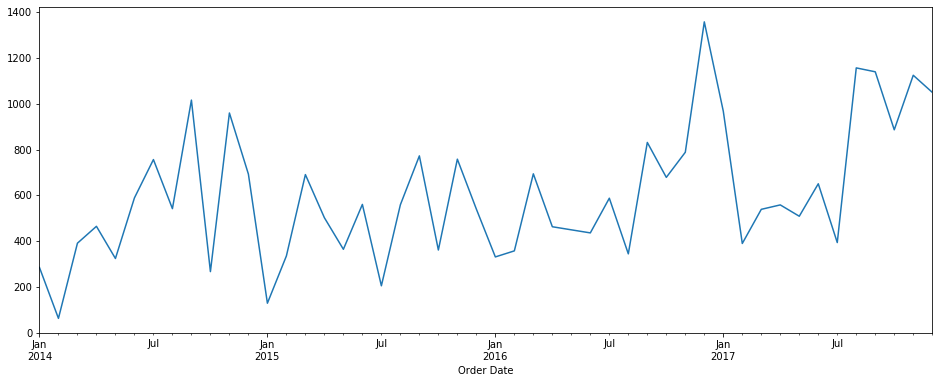

In [10]:
plt.rcParams['figure.figsize']=16,6
y.plot()

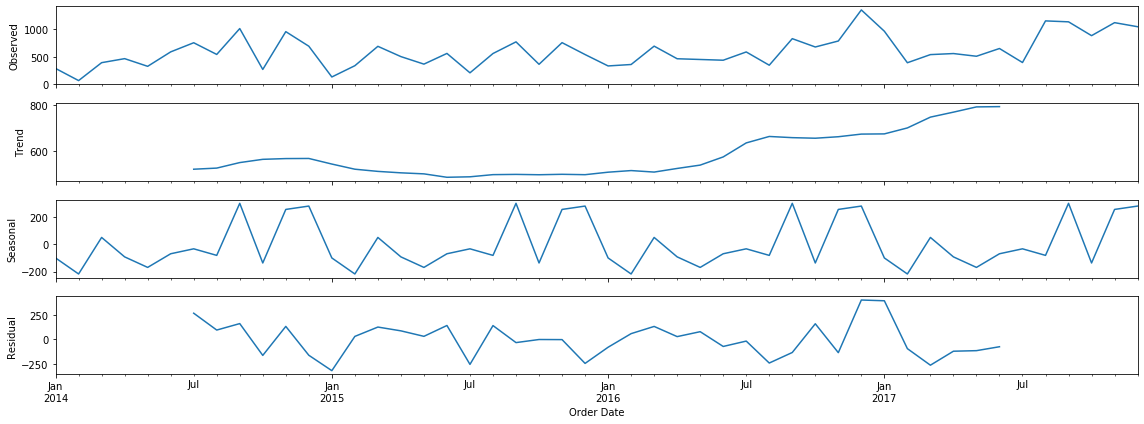

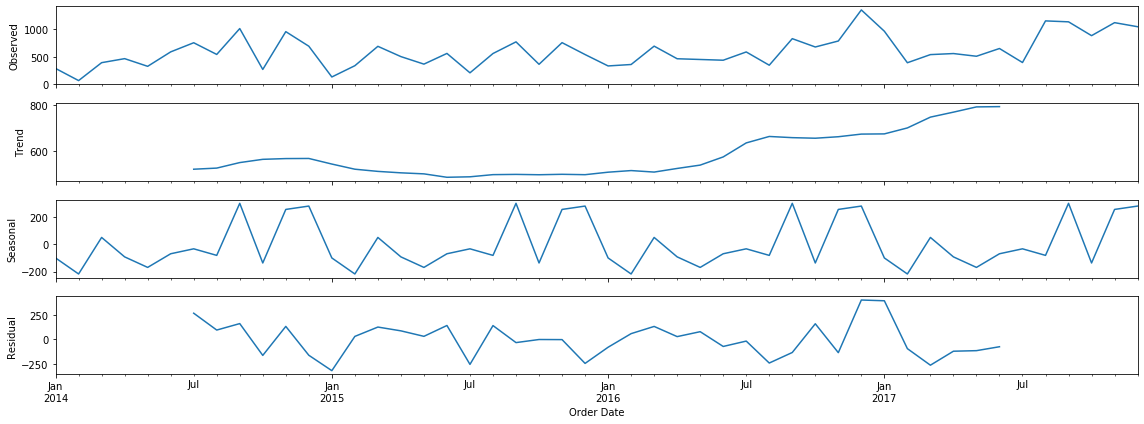

In [11]:
decomp=sm.tsa.seasonal_decompose(y)
decomp.plot()

In [53]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean() 
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.stattools.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    #Plotting ACF
    sm.tsa.graphics.plot_acf(timeseries)
    sm.tsa.graphics.plot_pacf(timeseries)
    print (dfoutput)

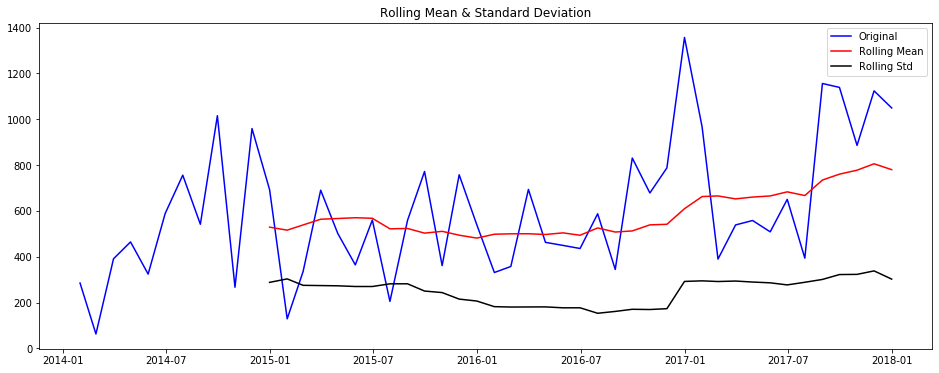

Results of Dickey-Fuller Test:
Test Statistic                 -4.664633
p-value                         0.000098
#Lags Used                      0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


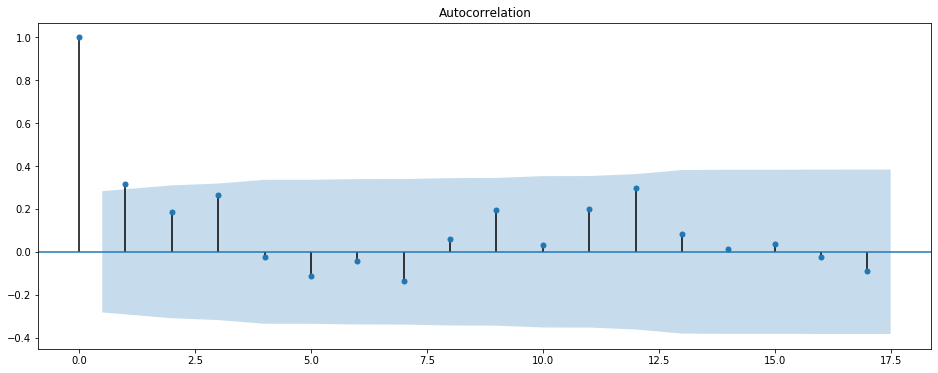

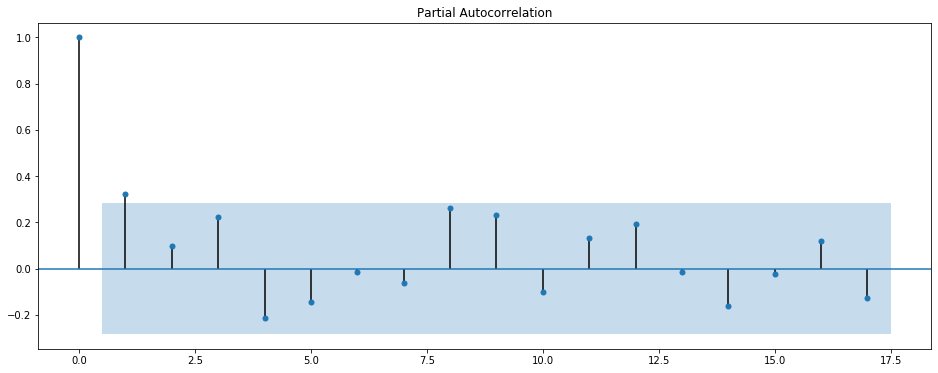

In [54]:
test_stationarity(y)

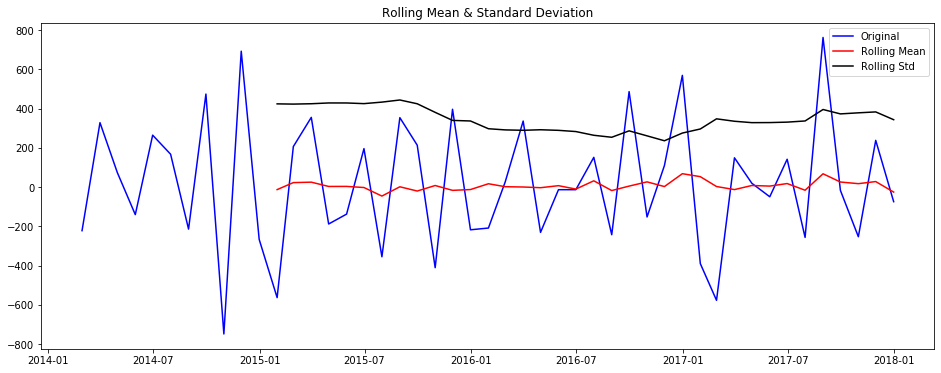

Results of Dickey-Fuller Test:
Test Statistic                -8.603123e+00
p-value                        6.784148e-14
#Lags Used                     1.000000e+00
Number of Observations Used    4.500000e+01
Critical Value (1%)           -3.584829e+00
Critical Value (5%)           -2.928299e+00
Critical Value (10%)          -2.602344e+00
dtype: float64


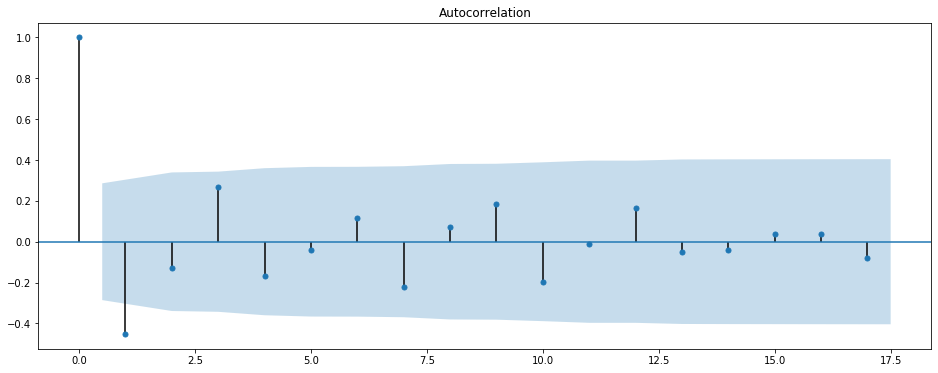

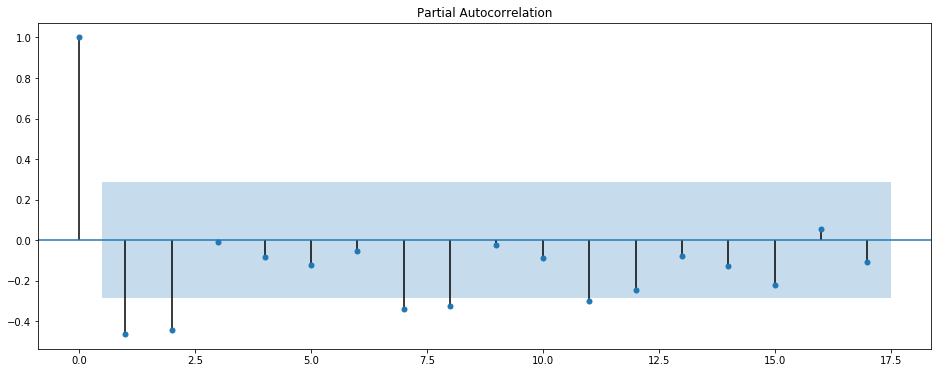

In [55]:
test_stationarity(y.diff().dropna())

Fast decay noted in acf plot for 1st Order differencing

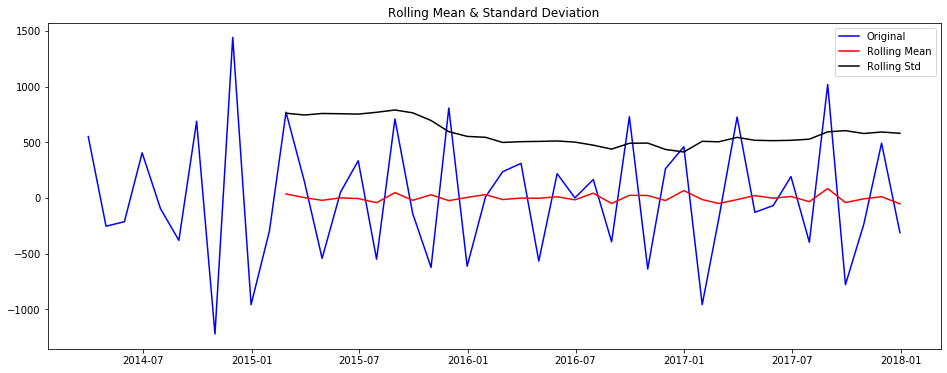

Results of Dickey-Fuller Test:
Test Statistic                 -4.361977
p-value                         0.000346
#Lags Used                      7.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


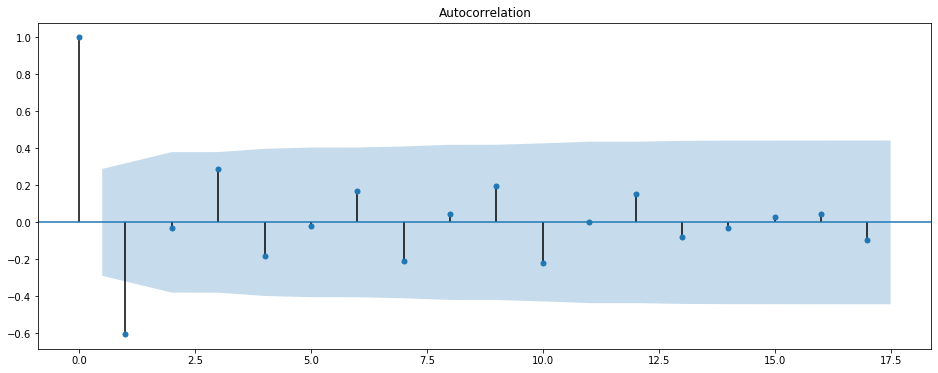

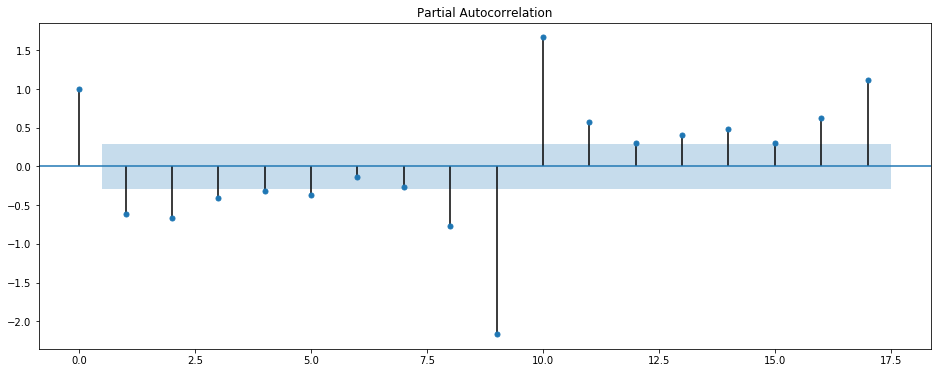

In [56]:
test_stationarity(y.diff().diff().dropna())

2nd order differencing has less ADF and more p -value as compared to the 1st order differencing.

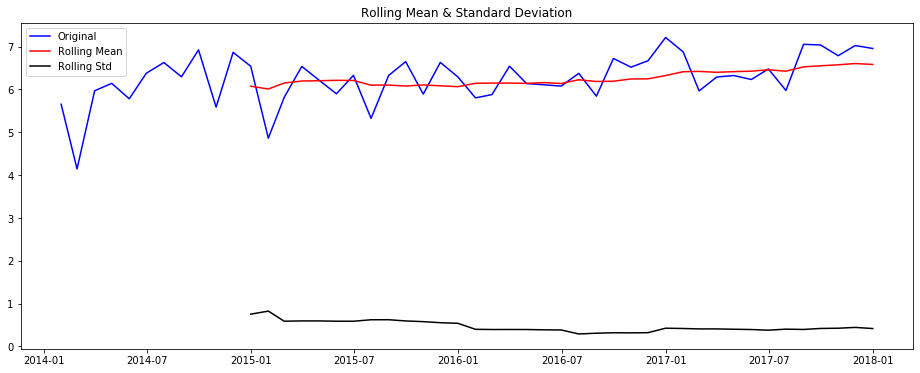

Results of Dickey-Fuller Test:
Test Statistic                 -2.859756
p-value                         0.050232
#Lags Used                      2.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64


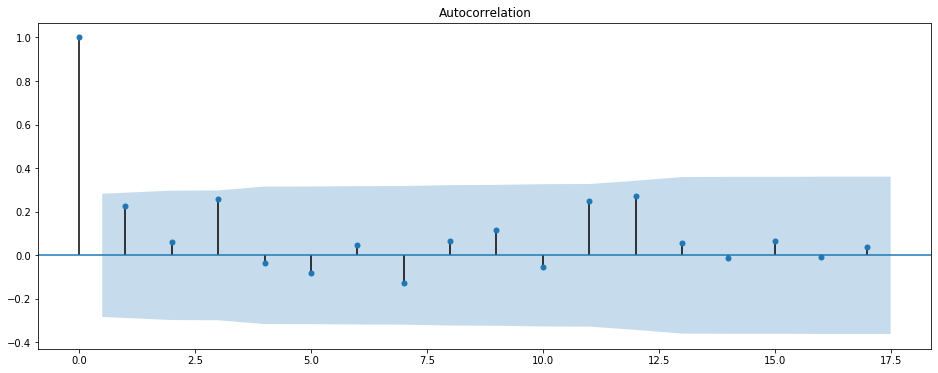

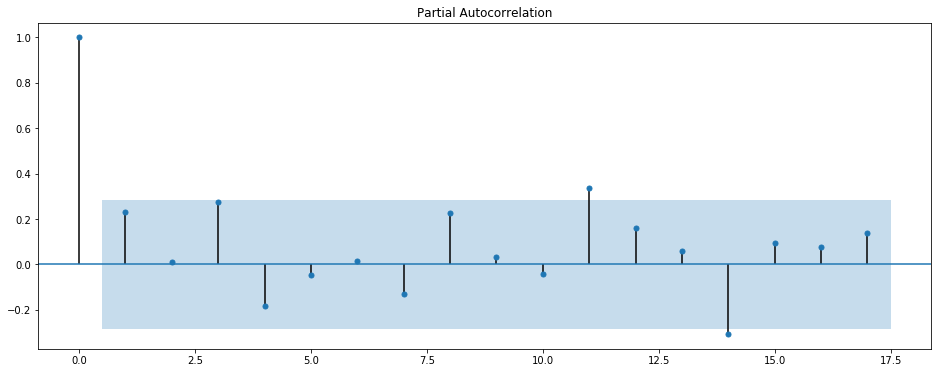

In [57]:
test_stationarity(np.log(y).dropna())

Slow acf decay and less ADF and value which means data not stationary

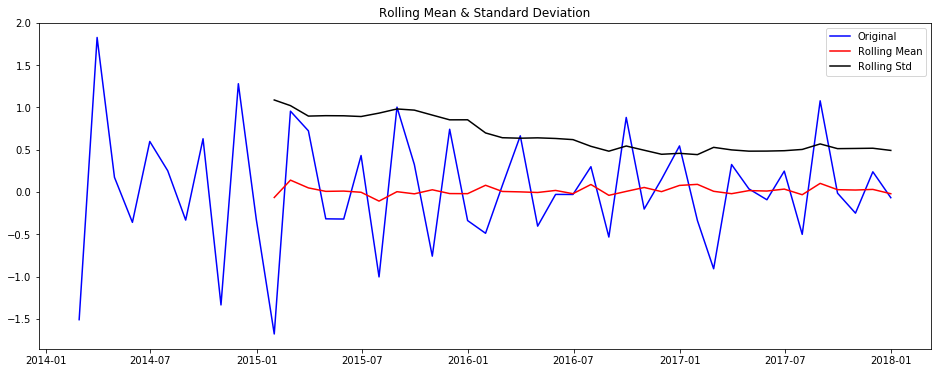

Results of Dickey-Fuller Test:
Test Statistic                 -4.771865
p-value                         0.000062
#Lags Used                      9.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


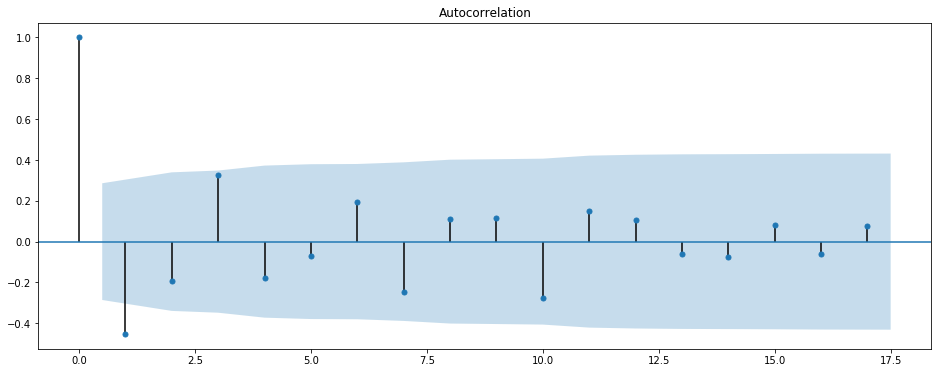

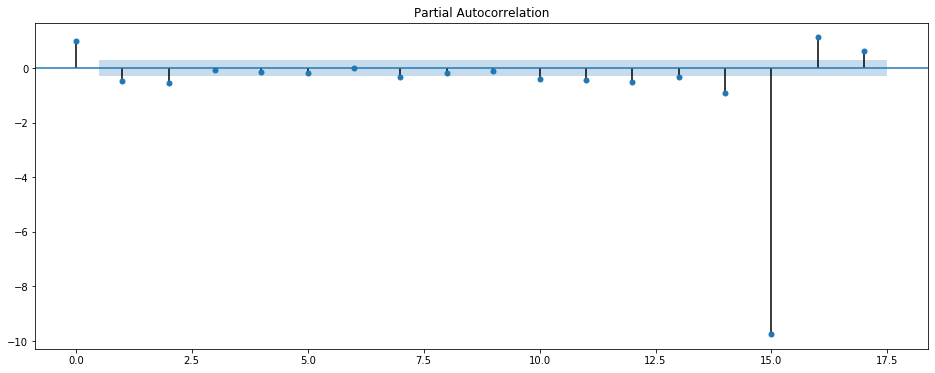

In [58]:
test_stationarity(np.log(y).diff().dropna())

Still lower ADF value as compared to 1st order differencing. So we will stick with d of order 1  ar in the range of 1 and ma in the range of 2

In [60]:
import itertools

In [61]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [63]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:747.1990404227043
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1305.415422254443
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:500.7335398801037


C:\Users\bishw\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\bishw\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:516.0876543936832
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1498.692131146344
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:347.44488563489716

C:\Users\bishw\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:702.6891395292472
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3088.2447526044443
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:487.7601415814759
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:517.4952646586494
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:345.6922094460085


C:\Users\bishw\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:666.4572045007284
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1317.0470455568263
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:503.0840747512458

C:\Users\bishw\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\bishw\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:500.0109385290892
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1440.828400502745
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:335.7148959418817
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:637.3530008828161
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2839.6493099359077
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:473.71539674554106
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:489.94199700276977
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2591.0370458143943
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:330.7061513093236
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:680.4032716562346


C:\Users\bishw\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1555.782711466129
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:501.7031226672368
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:500.21905344214457


C:\Users\bishw\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1454.2896575412694
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:331.0719973254953
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:651.1768264308268
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:81552.57767185626
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:488.431419613282
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:489.25464004381257
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2639.809006878239


C:\Users\bishw\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:331.71368022735686
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:658.0713305703066
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:2025.8321186075195
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:494.9076797373941
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:482.80837530249556


C:\Users\bishw\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1353.3803448764345
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:321.2325469884308
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:638.7962401173412
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:5107.194265998252
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:475.713885195653
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:478.69873017432724
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:3727.638685991509
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:318.20664790847013


We have to the least AIC for ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:318.20664790847013

In [65]:
ts=sm.tsa.statespace.SARIMAX(y, order=(1,1,1), seasonal_order=(1,1,0,12), enforce_invertibility=False, enforce_stationarity=False)

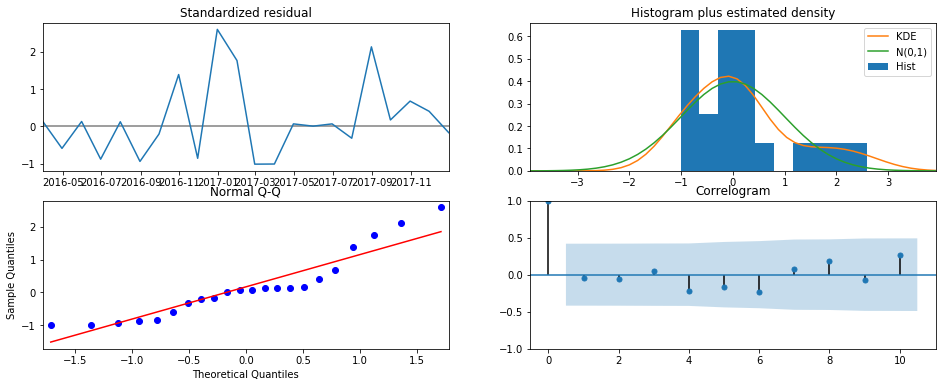

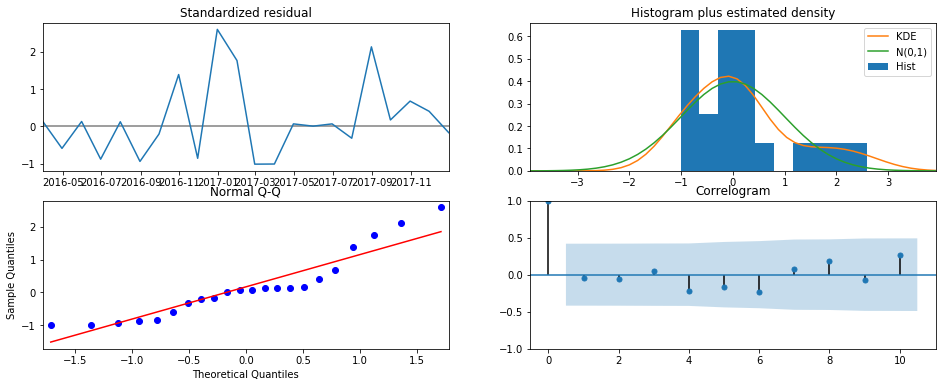

In [74]:
tsmod=ts.fit()
tsmod.summary()
tsmod.plot_diagnostics()

In [79]:
pred = results.get_prediction(start=pd.to_datetime('2017-05-31'), dynamic=False)
pred_ci = pred.conf_int()

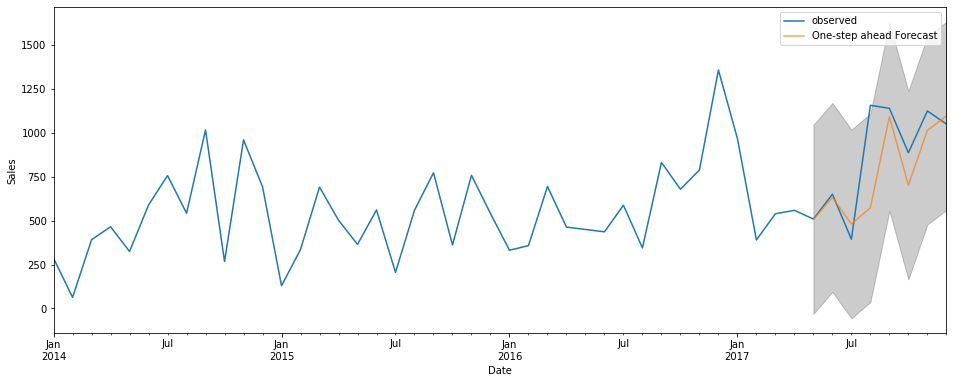

In [80]:
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

In [81]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

In [82]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-05-31':]

In [84]:
forecast_accuracy(y_forecasted, y_truth)

{'mape': 0.1436212377715933,
 'me': -101.71823380826638,
 'mae': 134.86334980474976,
 'mpe': -0.07768426083730169,
 'rmse': 223.16988201479126,
 'corr': 0.7315555772548317,
 'minmax': 0.138433308589627}

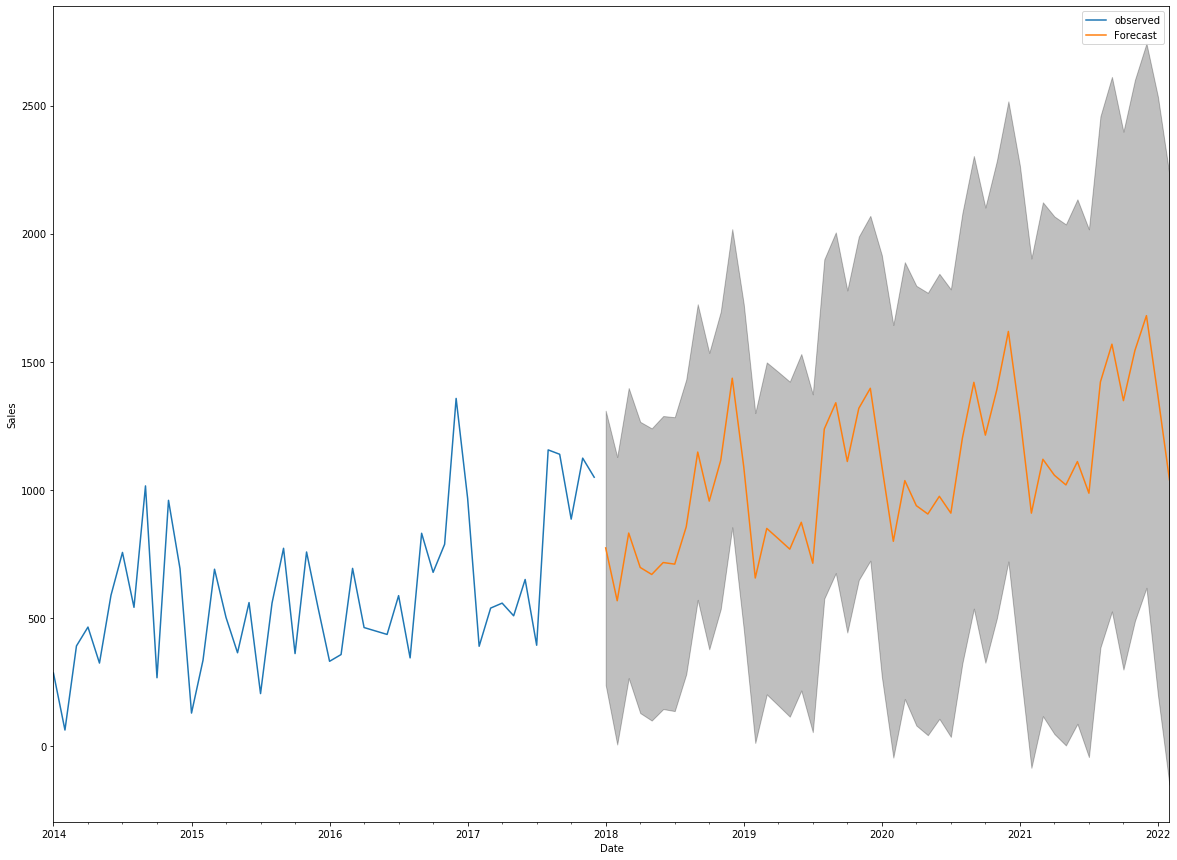

In [85]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=50)
# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
#We can use the output of this code to plot the time series and forecasts of its future values.

ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

In [86]:
print(pred_uc.predicted_mean)

2018-01-31     773.681793
2018-02-28     567.545617
2018-03-31     831.634158
2018-04-30     697.463804
2018-05-31     670.114798
2018-06-30     716.646484
2018-07-31     710.375738
2018-08-31     855.974022
2018-09-30    1147.713794
2018-10-31     956.373165
2018-11-30    1115.563498
2018-12-31    1435.922712
2019-01-31    1090.007430
2019-02-28     656.262811
2019-03-31     849.753724
2019-04-30     809.757166
2019-05-31     768.847243
2019-06-30     873.757360
2019-07-31     713.931544
2019-08-31    1237.848715
2019-09-30    1340.167045
2019-10-31    1110.941735
2019-11-30    1318.461797
2019-12-31    1396.594294
2020-01-31    1093.653720
2020-02-29     799.549020
2020-03-31    1036.352242
2020-04-30     938.579175
2020-05-31     905.989001
2020-06-30     975.083402
2020-07-31     909.465065
2020-08-31    1201.280043
2020-09-30    1419.810208
2020-10-31    1213.827506
2020-11-30    1391.696825
2020-12-31    1618.437690
2021-01-31    1289.131729
2021-02-28     909.356626
2021-03-31  